## Extreme Gradient Boosting (XGBoost)

Extreme gradient boost algorithm is an improved generalized gradient boosting algorithm  that can be used for both classification and regression tasks, which uses decision trees as base learners.

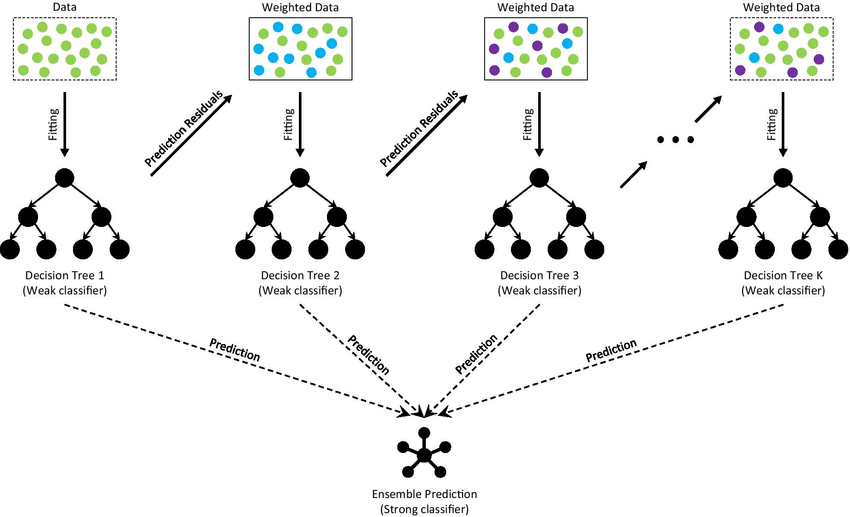

Unlike gradient boosting, XGBoost introduces feature-based parallel computing and cache awareness that makes it approximately 10 times faster than traditional gradient boosting by storing gradients and hessian (2nd derivate of loss function) weights in cache for computing similarity scores and output value. It also includes a unique split-finding algorithm to optimize trees with regularization to reduce overfitting.

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of Extreme Gradient Boost:</b>
1. Able to handle missing data
2. Parallel computing that results in fast execution time
3. Captures non-linear relationships
4. Suitable for larger datasets

<b>Disadvantages of Extreme Gradient Boost:</b>
1. Prone to overfitting, such that outliers may be overemphasized unless regularization is used
2. Large space of hyperparameter tuning required
3. Difficult to interpret final model

<b>Time complexity of model training: O(mkxlogn)</b>

<b>Time complexity of model prediction: O(mk)</b>

n - Number of training samples

x - Number of non-missing training samples

k - Depth of decision tree

m - Number of decision trees

<b>How does XGBoost handle missing values?:</b> Missing data is handled using sparsity awareness, where residuals are still calculated for missing values based on intial estimate and similarity score is calculated by assigning missing data to both left and right side of tree respectively.

<b>How does XGBoost handle categorical data?:</b> Categorical data is supported, where split happened depending on whether partitioning or one-hot encoding is used.

Extra Notes:
1. Dart booster in XGBoost involves adding dropout techniques from neural networks to boosted trees to solve overfitting issue
2. XGBoost grows trees level wise

More details about XGBoost can be found in the following official documentation: https://xgboost.readthedocs.io/en/stable/index.html

## Tree methods for XGBoost

1. Exact: Vanilla Gradient Boosting Decision Tree algorithm method, where all entries of input data is used during every split finding procedure (Greedy-based algorithm)

2. Approx: Approximate greedy based algorithm that uses quantiles as thresholds during split finding procedure (approximately 33 weighted quantiles by default) using hessian weights

3. hist: Approximate greedy based algorithm that uses quantiles as thresholds during split finding procedure (approximately 33 weighted quantiles by default) using user-provided weights

Note that approx and hist method is suitable to use for large datasets only.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from xgboost import XGBClassifier, XGBRegressor
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## XGBoost for regression

<b>Important hyperparameters for XGBRegressor</b>:
1. booster: booster algorithm to use for XGBoost (gbtree, gblinear, dart)
2. objective : Specifies the learning task and the related learning objective. Represents the loss function to be minimized in the formula. ('reg:squarederror', 'reg:logistic', 'reg:absoluteerror', 'reg:squaredlogerror', 'reg:pseudohubererror')
3. eta: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between eta and num_round values)
4. num_round: Maximum number of estimators before boosting algorithm terminates
5. gamma: Minimum loss reduction required to make further partition on leaf node (Post-pruning approach)
6. min_child_weight: Minimum sum of instance weight required in child node for further partition
7. max_depth: Maximum depth of decision tree
8. subsample: Fraction of samples used to fit individual base learners
9. colsample_by_tree: Subsample ratio of columns when constructing each tree
10. lambda: l2 regularization term on weights
11. alpha: l1 regularization term on weights
12. rate_drop: Fraction of previous trees to drop (for dart booster)

For regression tasks, extreme gradient boost algorithm makes final prediction from test data by using the following formula:

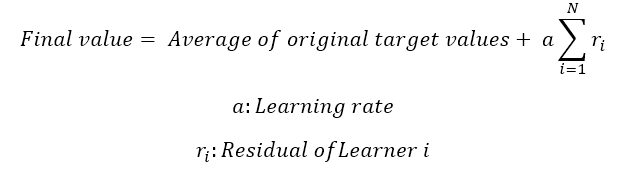

## Practical steps of Extreme Gradient Boost algorithm (Regression)

The following steps are involved in the extreme gradient boost algorithm for regression:

1) Set initial predicted value as average of all target values on all rows of the dataset.

2) Compute residual for every row using the following formula:

- <b>Residual = Actual value - Average target value</b>

3) Construct decision tree with residuals as output in leaf nodes

4) Compute similarity weights for leaf nodes and root node using the following formula:

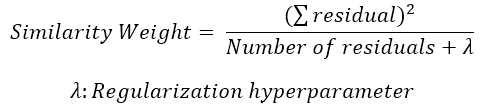

- <b>Note that "cover" (denoted by min_child_weight hyperparameter) represents the number of residuals for regression.</b>

- <b>Note that the regularization hyperparameter reduces the sensitivity of prediction values to individual observations.</b>

5) Compute information gain for given decision tree using the following formula:

- <b>Information gain = Similarity weight of leaf nodes - Similarity weight of current node of interest</b>

6) Repeat steps 3 to 5 for all different types of splits until no further split is possible and select decision tree with <b>highest information gain</b> at every point of node split.

7) For multiple residuals belonging to the same leaf node, an <b>average of residuals</b> will be computed as the output of the given leaf node.

8) Compute new predicted value for all rows in the dataset as follows:

- <b>New predicted value = Previous predicted value + Learning rate * (Output from Decision Tree)</b>

9) Repeat from steps 2 to 8 until number of estimators is reached as specified in the model.

In [3]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [4]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [5]:
reg = XGBRegressor(random_state=120, num_round=100, objective = 'reg:squarederror', eval_metric='rmse', verbosity=0, tree_method = 'hist', single_precision_histogram=True)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__booster'] = Categorical(['gbtree','dart'])
search_space['regression__rate_drop'] = Real(0.0001,1,'log-uniform')
search_space['regression__eta'] = Real(0.1,0.5,'log-uniform')
search_space['regression__gamma'] = Real(0.1,20,'log-uniform')
search_space['regression__min_child_weight'] = Real(0.1,1000,'log-uniform')
search_space['regression__max_depth'] = Integer(1,10)
search_space['regression__subsample'] = Real(0.5,1,'log-uniform')
search_space['regression__lambda'] = Real(0.1,1000,'log-uniform')
search_space['regression__alpha'] = Real(0.1,100,'log-uniform')
search_space['regression__colsample_bytree'] = Real(0.5,1,'log-uniform')
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 1.053184865819968
Best hyperparameters for fold 1: OrderedDict([('regression__alpha', 82.37444251419784), ('regression__booster', 'dart'), ('regression__colsample_bytree', 0.646101368776316), ('regression__eta', 0.10627479889936128), ('regression__gamma', 0.5447342783348211), ('regression__lambda', 910.506844451864), ('regression__max_depth', 4), ('regression__min_child_weight', 1.6052986423522106), ('regression__rate_drop', 0.3040459484911004), ('regression__subsample', 0.9054104243144621)])
Test RMSE for fold 1: 0.9765145632325706
Validation RMSE for fold 2: 0.8203719067606284
Best hyperparameters for fold 2: OrderedDict([('regression__alpha', 12.262793200733586), ('regression__booster', 'dart'), ('regression__colsample_bytree', 0.5405094037886798), ('regression__eta', 0.284442365855134), ('regression__gamma', 2.224862997103262), ('regression__lambda', 41.012954534138416), ('regression__max_depth', 6), ('regression__min_child_weight', 2.4393534942078157), 

## XGBoost for Classification

<b>Important hyperparameters for XGBClassifier</b>:
1. booster: booster algorithm to use for XGBoost (gbtree, gblinear, dart)
2. objective : Specifies the learning task and the related learning objective. Represents the loss function to be minimized in the formula. ('binary:logistic', 'multi:softmax', 'multi:softprob')
3. eta: Weight applied to each regressor at each boosting iteration. Higher learning rate increases contribution of each regressor. (Tradeoff between eta and num_round values)
4. num_round: Maximum number of estimators before boosting algorithm terminates
5. gamma: Minimum loss reduction required to make further partition on leaf node (post pruning approach)
6. min_child_weight: Minimum sum of instance weight required in child node for further partition
7. max_depth: Maximum depth of decision tree
8. subsample: Fraction of samples used to fit individual base learners
9. colsample_by_tree: Subsample ratio of columns when constructing each tree
10. lambda: l2 regularization term on weights
11. alpha: l1 regularization term on weights
12. rate_drop: Fraction of previous trees to drop (for dart booster)

<b>Methods to handle imbalanced dataset for classification</b>:
1. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)
2. Assign class weights to scale_pos_weight hyperparameter for binary classification
3. Use AUC as evaluation metric for multiclass classification
4. Set max_delta_step paramter to finite value (e.g 1) for prediting probabilities accurately

For classification tasks, extreme gradient boost algorithm makes final prediction from test data by using the following formula:

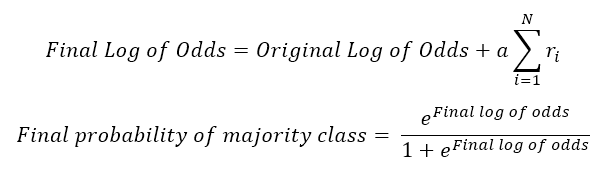

## Practical steps of Extreme Gradient Boost algorithm (Binary Classification)

The following steps are involved in the extreme gradient boost algorithm for binary classification:

1) Set initial predicted probability of target class to constant value for all rows in the dataset.

2) Compute initial log of odds using the following formula:

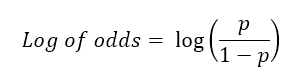

3) Compute residual for every row using the following formula:

- <b>Residual = Actual class (0/1) - Predicted probability</b>

4) Construct decision tree with residuals as output in leaf nodes

5) Compute similarity weights for leaf nodes and root node using the following formula:

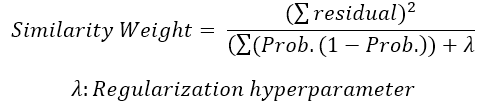

- <b>Note that "cover" (denoted by min_child_weight hyperparameter) represents the summation of predicted probability multiplied by its complement for classification.</b>

- <b>Note that the regularization hyperparameter reduces the sensitivity of prediction values to individual observations.</b>

6) Compute information gain for given decision tree using the following formula:

- <b>Information gain = Similarity weight of leaf nodes - Similarity weight of current node of interest</b>

7) Repeat steps 4 to 6 for all different types of splits until no further split is possible and select decision tree with <b>highest information gain</b> at every point of node split.

8) Output from leaf nodes are computed as follows:

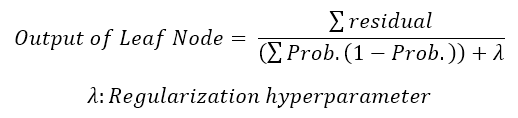

9) Compute new predicted log of odds for all rows in the dataset as follows:

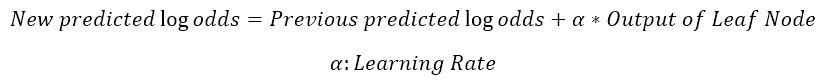

10) Compute new predicted probability for all rows in the dataset using sigmoid function as follows:

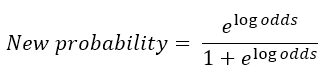

11) Repeat from steps 3 to 10 until number of estimators is reached as specified in the model.

In [6]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [7]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [8]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - XGBClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9494454033160006
Best hyperparameters for fold 1: OrderedDict([('classification__alpha', 0.11341166444577101), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.7838173301963387), ('classification__eta', 0.24191622669152837), ('classification__gamma', 3.8783670573743954), ('classification__lambda', 0.32023858902750946), ('classification__max_depth', 4), ('classification__min_child_weight', 11.859012095963555), ('classification__rate_drop', 0.001665176114024899), ('classification__subsample', 0.5996240342676964)])
Test F1 score for fold 1: 0.9373219373219372



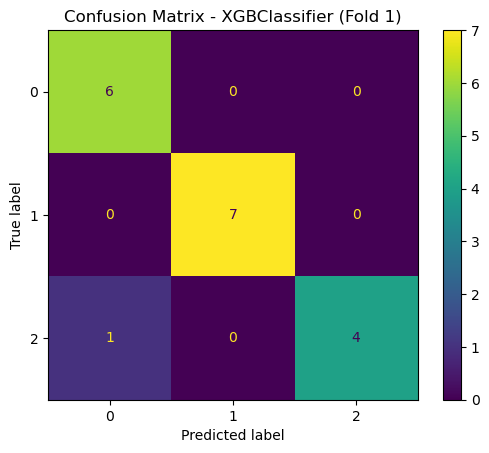


Validation F1 score for fold 2: 0.9624472761899063
Best hyperparameters for fold 2: OrderedDict([('classification__alpha', 0.2475171858913277), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.5791042267353859), ('classification__eta', 0.1355320774271667), ('classification__gamma', 0.2461966466380425), ('classification__lambda', 4.550906452202013), ('classification__max_depth', 4), ('classification__min_child_weight', 0.3541451403835363), ('classification__rate_drop', 0.027591231082749582), ('classification__subsample', 0.6771892050051976)])
Test F1 score for fold 2: 1.0



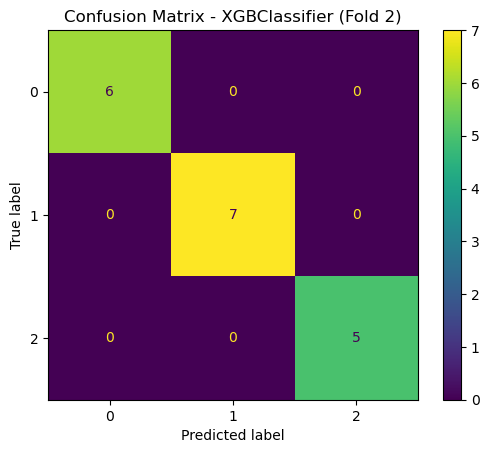


Validation F1 score for fold 3: 0.585711184526974
Best hyperparameters for fold 3: OrderedDict([('classification__alpha', 0.1091163827253578), ('classification__booster', 'gbtree'), ('classification__colsample_bytree', 0.8922224113048661), ('classification__eta', 0.24719124630377637), ('classification__gamma', 10.814769100290466), ('classification__lambda', 37.06143714852904), ('classification__max_depth', 10), ('classification__min_child_weight', 0.3290059319912467), ('classification__rate_drop', 0.00030463296908079667), ('classification__subsample', 0.6850471205221963)])
Test F1 score for fold 3: 0.8897028897028897



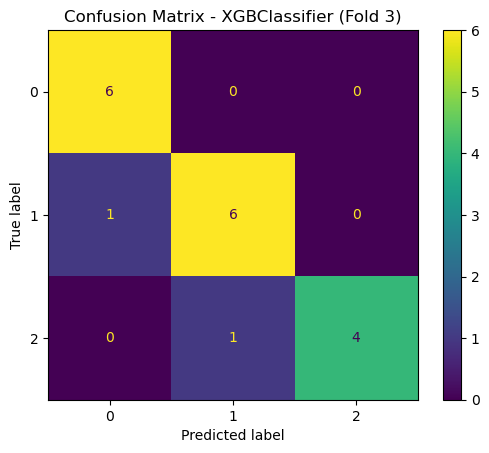


Validation F1 score for fold 4: 0.9402714863602067
Best hyperparameters for fold 4: OrderedDict([('classification__alpha', 1.044106266555959), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.6105569332215076), ('classification__eta', 0.18660665213639654), ('classification__gamma', 0.12299356458778794), ('classification__lambda', 30.39326704453941), ('classification__max_depth', 2), ('classification__min_child_weight', 0.2620023804014438), ('classification__rate_drop', 0.4263410117949783), ('classification__subsample', 0.8497520235407469)])
Test F1 score for fold 4: 1.0



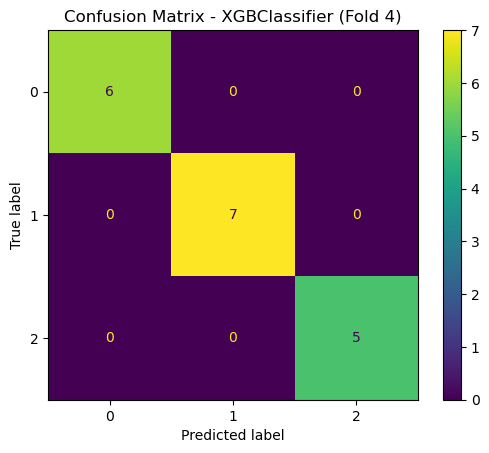


Validation F1 score for fold 5: 0.9360983397190292
Best hyperparameters for fold 5: OrderedDict([('classification__alpha', 0.24044620590201957), ('classification__booster', 'gbtree'), ('classification__colsample_bytree', 0.7765674727991594), ('classification__eta', 0.2691252406045695), ('classification__gamma', 0.11836774749992147), ('classification__lambda', 0.2231539114791149), ('classification__max_depth', 2), ('classification__min_child_weight', 4.779310638393959), ('classification__rate_drop', 0.056933951792914834), ('classification__subsample', 0.9495204918690293)])
Test F1 score for fold 5: 1.0



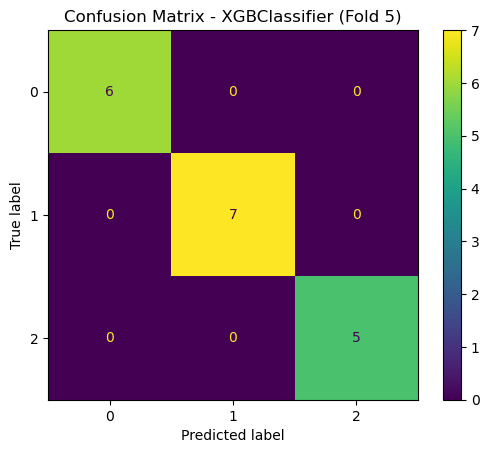


Validation F1 score for fold 6: 0.9570200277728882
Best hyperparameters for fold 6: OrderedDict([('classification__alpha', 0.13892544320921074), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.6434141231728349), ('classification__eta', 0.44938835378462944), ('classification__gamma', 0.22205385317566728), ('classification__lambda', 0.5620818775522313), ('classification__max_depth', 7), ('classification__min_child_weight', 3.801958014399074), ('classification__rate_drop', 0.12490736113059167), ('classification__subsample', 0.7811877790203763)])
Test F1 score for fold 6: 1.0



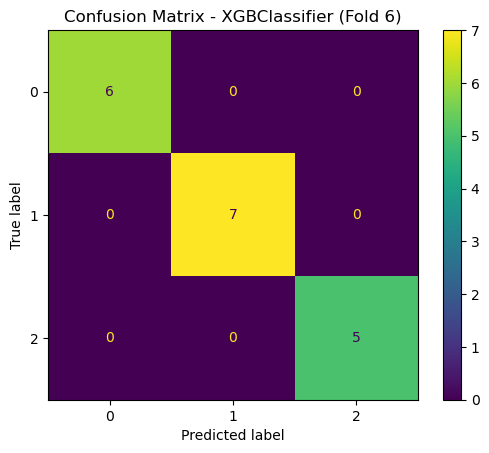


Validation F1 score for fold 7: 0.9494005989208125
Best hyperparameters for fold 7: OrderedDict([('classification__alpha', 0.13492628745050678), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.5629492434353562), ('classification__eta', 0.12191440082918079), ('classification__gamma', 0.27591806686880016), ('classification__lambda', 126.43243735909677), ('classification__max_depth', 8), ('classification__min_child_weight', 0.14274952788788922), ('classification__rate_drop', 0.00039337472098208793), ('classification__subsample', 0.7084613225490274)])
Test F1 score for fold 7: 1.0



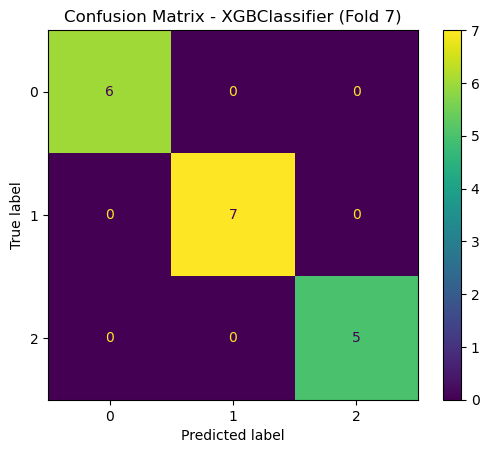


Validation F1 score for fold 8: 0.9497590734547255
Best hyperparameters for fold 8: OrderedDict([('classification__alpha', 0.8074924927787543), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.9090750462311491), ('classification__eta', 0.1202876101746935), ('classification__gamma', 1.9006418936169316), ('classification__lambda', 2.3905000532993546), ('classification__max_depth', 1), ('classification__min_child_weight', 0.8261700449886984), ('classification__rate_drop', 0.013231800891094818), ('classification__subsample', 0.7464801646363791)])
Test F1 score for fold 8: 0.8917748917748917



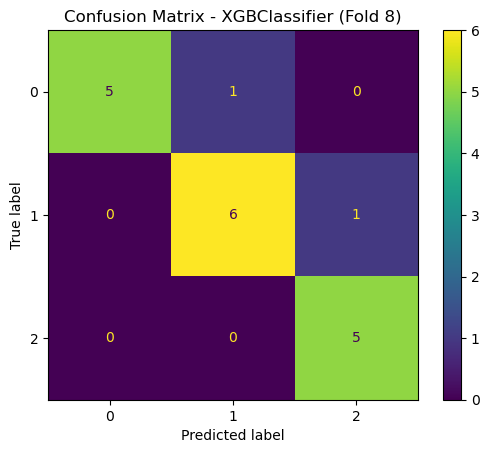


Validation F1 score for fold 9: 0.9638665750874662
Best hyperparameters for fold 9: OrderedDict([('classification__alpha', 0.12170395522305999), ('classification__booster', 'dart'), ('classification__colsample_bytree', 0.6209239236771975), ('classification__eta', 0.2330473430415472), ('classification__gamma', 0.4451836965888028), ('classification__lambda', 0.334184839746749), ('classification__max_depth', 2), ('classification__min_child_weight', 0.10022264831738717), ('classification__rate_drop', 0.08513113426864487), ('classification__subsample', 0.5300471034610541)])
Test F1 score for fold 9: 0.9373219373219372



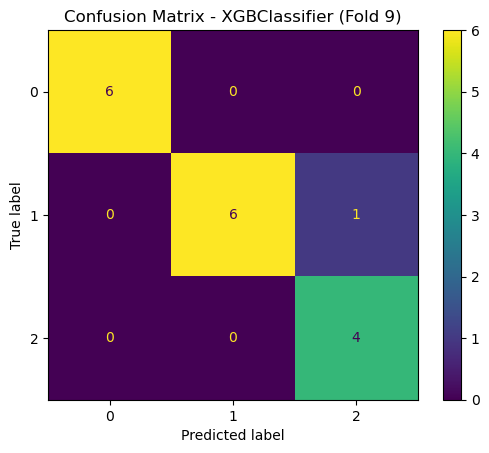


Validation F1 score for fold 10: 0.9554933337287176
Best hyperparameters for fold 10: OrderedDict([('classification__alpha', 2.427205009211467), ('classification__booster', 'gbtree'), ('classification__colsample_bytree', 0.8567361685195729), ('classification__eta', 0.13145959736634039), ('classification__gamma', 0.23946423442465503), ('classification__lambda', 1.7234368154382682), ('classification__max_depth', 5), ('classification__min_child_weight', 0.7290259921090936), ('classification__rate_drop', 0.001567578105099666), ('classification__subsample', 0.7926095854234868)])
Test F1 score for fold 10: 0.9407407407407408



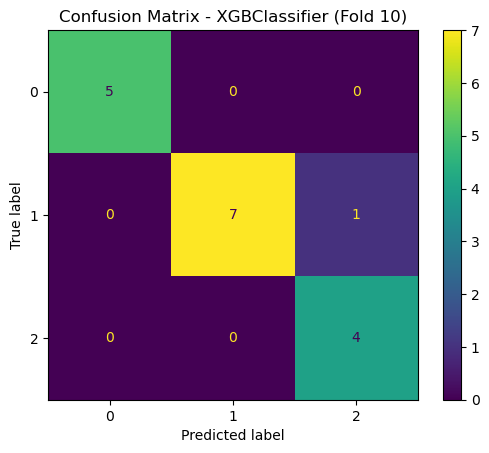


----------------------
Average validation F1 score: 0.9149513299076728
Average test F1 score: 0.9596862396862397


In [9]:
clf = XGBClassifier(random_state=120, num_round=100, objective = 'multi:softmax', eval_metric='aucpr', verbosity=0, tree_method = 'exact')
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__booster'] = Categorical(['gbtree','dart'])
search_space['classification__rate_drop'] = Real(0.0001,1,'log-uniform')
search_space['classification__eta'] = Real(0.1,0.5,'log-uniform')
search_space['classification__gamma'] = Real(0.1,20,'log-uniform')
search_space['classification__min_child_weight'] = Real(0.1,1000,'log-uniform')
search_space['classification__max_depth'] = Integer(1,10)
search_space['classification__subsample'] = Real(0.5,1,'log-uniform')
search_space['classification__lambda'] = Real(0.1,1000,'log-uniform')
search_space['classification__alpha'] = Real(0.1,100,'log-uniform')
search_space['classification__colsample_bytree'] = Real(0.5,1,'log-uniform')
nested_cv(X, y, pipeline, search_space)

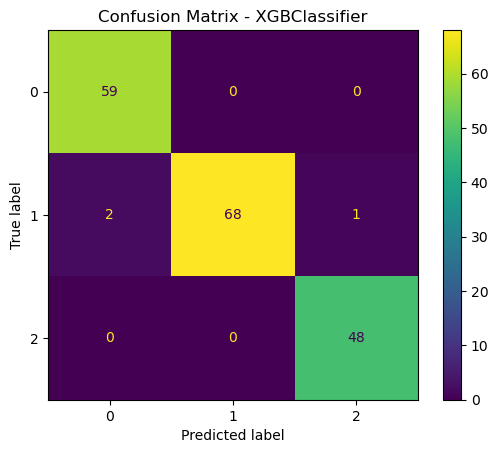

In [10]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - XGBClassifier")
plt.grid(False)
plt.show()